# NeuroLoops: Exploring Feedback Loops in _C. elegans_
This project explores the role of feedback circuits in the nervous system of _C. elegans_ using the connectivity graphs in the [WormAtlas](http://www.wormatlas.org/) database.  Special thanks to Russ Poldrack for notebook starter code in his [Brain Networks Course](https://github.com/BrainNetworksCourse).

In [32]:
import pandas as pd
import numpy as np
import os, sys, operator, scipy.stats, json
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats
from networkx.algorithms import community
from collections import Counter

%matplotlib inline

# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details
celegans_connectome=pd.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

INCLUDE_ELECTRIC_JUNCTIONS = False

# set up the graph
G = nx.DiGraph()
def add_edge_nbr(fn, tn, nbr):
    existing_edge = G.get_edge_data(fn, tn)
    if existing_edge is None:
        G.add_edge(fn, tn, weight=nbr)
    else:
        new_weight = existing_edge['weight'] + nbr
        G[fn][tn]['weight'] = new_weight
for i in celegans_connectome.index:
    entry = celegans_connectome.loc[i]
    fn = entry['Neuron 1']
    tn = entry['Neuron 2']
    nbr = entry['Nbr']
    typ = entry['Type']
    if typ in ['S','Sp']:
        add_edge_nbr(fn,tn,nbr)
    if typ == 'EJ' and INCLUDE_ELECTRIC_JUNCTIONS:
        add_edge_nbr(fn,tn,nbr)
        add_edge_nbr(tn,fn,nbr)

if False:
    nx.write_graphml(G, 'celegans.graphml')

In [33]:
# Utility Functions

def get_weight_histogram(graph):
    ''' Build a histogram of weights from a weighted graph '''
    return dict(Counter([graph[e[0]][e[1]]['weight'] for e in list(graph.edges)]))

def get_node_cluster_map(cluster_nodes):
    ''' Invert a cluster_node set to map node names to cluster index '''
    node_cluster_map = {}
    for cluster in range(len(cluster_nodes)):
        for node in cluster_nodes[cluster]:
            node_cluster_map[node] = cluster
    return node_cluster_map

def count_cycles(graph, cutoff=1e7):
    i = 0
    for c in nx.simple_cycles(graph):
        i += 1
        if i > cutoff:
            return '> {}'.format(cutoff)
    return str(i)

# Courtesy Russ Poldrack
def plot_adjmtx(G,bin=True):
    A = nx.to_numpy_array(G,weight='weight')
    if bin:
        A = (A>0).astype('int')
        cmap='gray'
    else:
        cmap='viridis'
    A = pd.DataFrame(A,columns=list(G.nodes),index=list(G.nodes))
    
    plt.imshow(A,cmap=cmap)
    if not bin:
        plt.colorbar()
    # set the axes to use name labels rather than numbers
    ax=plt.gca()
    node_list=list(G.nodes) 
    ax.set_yticks(np.arange(len(node_list)))
    ax.set_xticks(np.arange(len(node_list)))
    ax.set_xticklabels(node_list)
    ax.set_yticklabels(node_list)
    # add grid lines
#     for i in range(len(node_list)):
#         ax.axvline(x=i-0.5,color='b')
#         ax.axhline(y=i-0.5,color='b')

# Questions & Hypothesis
I was curious about cycles because of their relevance to persistent state representation.  This yielded the following questions about cycles in the _C. elegans_ neural graph:
- Does cyclicity vary for each community?
- Is the rich club more cyclic than the organism as a whole?
- What types of neurons tend to have more cyclicity?
- Are there common junctions in the larger cycles?
- Do the neurons that make up cycles vary in community or type?

For reference, below is a plot of the overall neural graph of _C. elegans_:

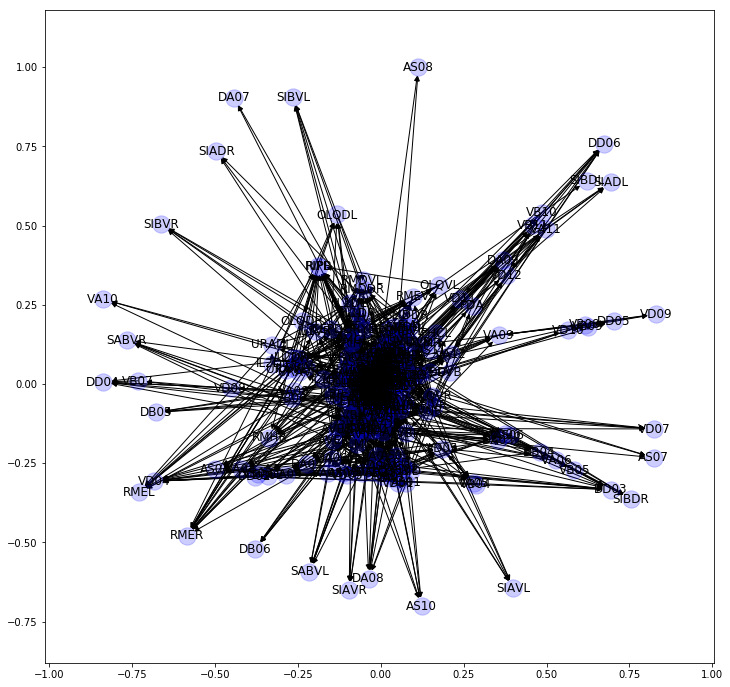

In [17]:
# Build plot
plt.figure(figsize=(12,12))
edge_expansion=12
node_expansion=30
layout = nx.spring_layout(G)
#weights=nx.get_edge_attributes(G,'weight')
_=nx.draw_networkx_edges(G,pos=layout, )
#                      width=[weights[i]*edge_expansion for i in G.edges],alpha=0.3)
_=nx.draw_networkx_nodes(G,pos=layout,
                         node_color='blue',
                         alpha=0.2,)
                        #node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=layout)

# Too Many Cycles
I first tried to search for all cycles by brute force, but this filled up my hard drive and crashed after identifying over 6 million cycles (over 11 gigabytes of cycles with no compression).  This meant analysis of cycles individually would be intractable for me.

In [ ]:
raise NotImplementedError  # This cell is not meant to be run!
with open('cycles.txt','a') as f:
    f.write('cycles = [\n')
    i = 0
    for c in nx.simple_cycles(G):
        line = '{},'.format(repr(c).replace(' ',''))
        f.write(line)
        i += 1
        if i % 1e5 == 0:
            print('Found {} cycles'.format(i))
        f.write(']\n\n\n')

# Clustering

### Girvan-Newman Clustering
My first test of clustering the graph used Girvan-Newman clustering to find communities.  This didn't work super well as a clustering method because the majority of the first clusters it found were single-node clusters.  However, this alone was interesting, and raised an interesting question: how is it that the edges out of a single node can have the highest betweenness centrality even when most of the edges connecting it have been removed?  I put this question on the back burner.

In [35]:
gn_clusters = community.centrality.girvan_newman(G)
for i in range(10):
    print('Iteration {} yielded communities of sizes {}'.format(i+1, [len(c) for c in next(gn_clusters)]))

Iteration 1 yielded communities of sizes [271, 8]
Iteration 2 yielded communities of sizes [266, 5, 8]
Iteration 3 yielded communities of sizes [265, 5, 8, 1]
Iteration 4 yielded communities of sizes [264, 5, 8, 1, 1]
Iteration 5 yielded communities of sizes [263, 1, 5, 8, 1, 1]
Iteration 6 yielded communities of sizes [89, 174, 1, 5, 8, 1, 1]
Iteration 7 yielded communities of sizes [89, 153, 21, 1, 5, 8, 1, 1]
Iteration 8 yielded communities of sizes [89, 146, 21, 7, 1, 5, 8, 1, 1]
Iteration 9 yielded communities of sizes [89, 144, 21, 7, 2, 1, 5, 8, 1, 1]
Iteration 10 yielded communities of sizes [89, 143, 21, 7, 2, 1, 1, 5, 8, 1, 1]


### Label Propagation Clustering
I tried Label Propagation Clustering, but it did not terminate after an hour of computation.

In [ ]:
lpa_clusters = community.label_propagation.asyn_lpa_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

### Greedy Modularity Clustering
Next, I tried greedy modularity clustering, which identified 12 communities, the largest of which contained 41 nodes.  Only one cluster had just a single node.  I felt this would be adequate as a starting point.

In [46]:
mod_clusters = community.modularity_max.greedy_modularity_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

Cluster sizes: [41, 39, 37, 35, 34, 30, 21, 15, 12, 7, 7, 1]


# Clusters to Graph
Given a clustering, I wanted to see what the connectivity between those clusters looked like.  For my first test, I simply included a directed edge between two clusters if there was a single edge of that direction between two nodes within those clusters.

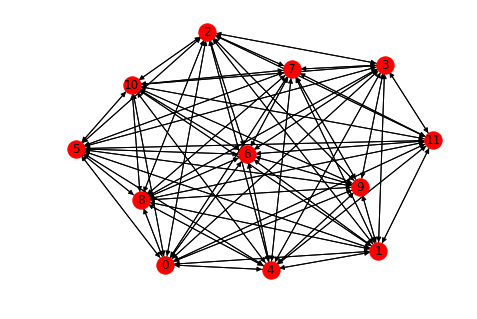

In [48]:
# Build a cluster lookup map indexed by node name
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        C.add_edge(from_cluster, to_cluster)
nx.draw_spring(C, with_labels=True)

This isn't particularly useful: every cluster has a bidirectional connection to almost every other.  I then tried weighting these connections by the number of connections between them.  This was interesting, as it revealed that the majority of possible cluster-to-cluster edges were instantiated by only a few edges in the full graph, whereas some connections were duplicated nearly 100 times.

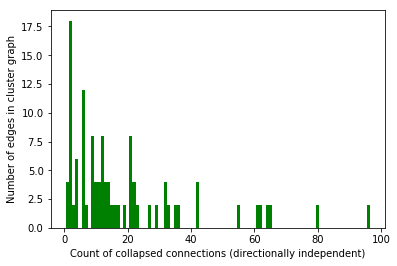

In [50]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = C.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            C.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            C[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(C)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.xlabel('Count of collapsed connections (directionally independent)')
plt.ylabel('Number of edges in cluster graph')
plt.show()

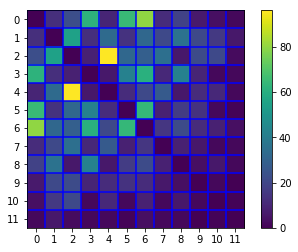

In [47]:
plot_adjmtx(C, False)

Quite interesting: most connections between clusters are weak, but there are some strongly connected outliers.  Let's see what happens if, for each edge, the direction and weight are determined by the difference between connections going each direction.

In [ ]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = C.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            C.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            C[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(C)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.show()

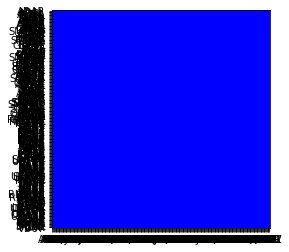

In [68]:
plot_adjmtx(G)

# Community Subgraphs

In [7]:
comgs = []
for cluster in range(len(cluster_nodes)):
    comgs.append(G.subgraph(cluster_nodes[cluster]))

print([len(c) for c in comgs])

[41, 39, 37, 35, 34, 30, 21, 15, 12, 7, 7, 1]


In [25]:
for sub in range(len(comgs)):
    print('Index={}, cycles = {}'.format(sub, count_cycles(comgs[sub])))

Index=0, cycles = > 10000000.0
Index=1, cycles = > 10000000.0
Index=2, cycles = > 10000000.0
Index=3, cycles = > 10000000.0
Index=4, cycles = > 10000000.0
Index=5, cycles = > 10000000.0
Index=6, cycles = 1627235
Index=7, cycles = 639
Index=8, cycles = 37985
Index=9, cycles = 78
Index=10, cycles = 12
Index=11, cycles = 0


The larger subgraphs have too many cycles to be useful.  Let's examine only subgraphs indexed 6 through 10.

In [51]:
def analyze_subgraph(g):
    cycles = []
    for c in nx.simple_cycles(g):
        x = {
            'nodes':c,
            'ct':len(c),
        }
        print(x)
    

analyze_subgraph(comgs[10])

{'nodes': ['PLNL', 'SMBVL', 'SAADL'], 'ct': 3}
{'nodes': ['PLNL', 'SMBVL'], 'ct': 2}
{'nodes': ['PLNL', 'SAADL', 'SMBVL'], 'ct': 3}
{'nodes': ['PLNL', 'SAADL'], 'ct': 2}
{'nodes': ['SMBDL', 'SAADL'], 'ct': 2}
{'nodes': ['SMBDL', 'SAADL', 'RMGR', 'ALNR'], 'ct': 4}
{'nodes': ['SMBDL', 'ALNR'], 'ct': 2}
{'nodes': ['SMBDL', 'ALNR', 'RMGR', 'SAADL'], 'ct': 4}
{'nodes': ['ALNR', 'RMGR'], 'ct': 2}
{'nodes': ['ADAR', 'RMGR'], 'ct': 2}
{'nodes': ['SMBVL', 'SAADL'], 'ct': 2}
{'nodes': ['RMGR', 'SAADL'], 'ct': 2}


### Cycle Count Normalization
To normalize cycle counts against possible counts, I needed to compute the total number of cycles possible in each group.  I considered both formulas on [this StackExchange question](https://math.stackexchange.com/questions/1363963/number-of-cycles-in-complete-graph), and settled on William Swartworth's equation: $C_{total} = 2\sum_{i=1}^{3} \frac{k!}{(k - i)!\cdot 2i} $ where $k=$ the number of nodes.

# Rich Club Cycles


RC has 13 nodes with cutoff 75


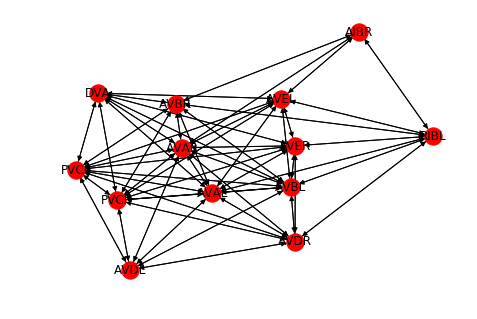

In [65]:
cutoff=75
G_highdegree=G.copy()
deg = dict(G_highdegree.degree())
to_remove = [n for n in deg if deg[n] <= cutoff]
G_highdegree.remove_nodes_from(to_remove)
print('RC has {} nodes with cutoff {}'.format(len(G_highdegree.nodes),cutoff))
nx.draw_spring(G_highdegree, with_labels=True)

In [67]:
print('Number of cycles within rich club = {}'.format(count_cycles(G_highdegree)))

Number of cycles within rich club = > 10000000.0


In [ ]:
plt.figure(figsize=(12,120))
cycle_lengths = [len(c) for c in cycles]
plt.hist(cycle_lengths)

Mean = 17.11743772241993
Maximum = 115


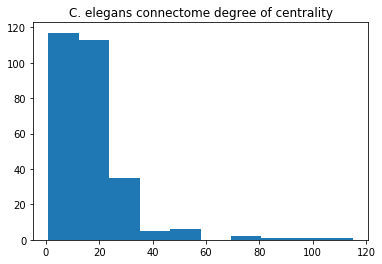

In [2]:
# Calculate degrees for each node
ce_degrees = [G.degree[i] for i in G.nodes]

# Calculate mean and max
ce_meandegree = numpy.mean(ce_degrees)
ce_maxdegree = numpy.max(ce_degrees)

# Plot and print
plt.title('C. elegans connectome degree of centrality')
plt.hist(ce_degrees)
print('Mean = {}'.format(ce_meandegree))
print('Maximum = {}'.format(ce_maxdegree))

b. Compute the average clustering coefficient for the connectome

In [3]:
ce_clustering = nx.average_clustering(G)
print(ce_clustering)

0.34604428028046025


c. Compute the average path length for the connectome

In [4]:
ce_avgpathlength = nx.average_shortest_path_length(G)
print(ce_avgpathlength)

2.324377224199288


#### Problem 2

First, use the provided code to create 100 random graphs with the same size as the C. Elegans connectome. For each graph, we compute its average clustering, average shortest path length, and maximum degree, and store those to a numpy array. (This may take a few minutes to run.)

In [5]:
# PROVIDED CODE
nruns=100
measures=['clustering','avgpathlength','maxdegree']
results=pandas.DataFrame(numpy.zeros((nruns,len(measures))),
                        columns=measures)

for i in range(nruns):
    G_rand = mk_random_graph(G)
    results.iloc[i]['clustering']=nx.average_clustering(G_rand)
    results.iloc[i]['avgpathlength']=nx.average_shortest_path_length(G_rand)
    results.iloc[i]['maxdegree']=numpy.max([G_rand.degree[i] for i in G_rand.nodes])


a.  Compute the tail probability of the observed values of cluster and path length for the C. elegans network, in comparison to the random network results.  That is, what is the probability of a value as or more extreme than the observed value wihtin the random graph distribution? You may find the function ```scipy.stats.percentileofscore()``` useful for this purpose.

In [6]:
### PROVIDED CODE: 

p_clustering= scipy.stats.percentileofscore(results['clustering'], ce_clustering)
print('Clustering  | Observed:',ce_clustering,'Random:',results['clustering'].mean(),'P<',p_clustering)

p_avgpathlength= scipy.stats.percentileofscore(results['avgpathlength'], ce_avgpathlength)
print('Path length | Observed:',ce_avgpathlength,'Random:',results['avgpathlength'].mean(),'P<',p_avgpathlength)

p_maxdegree= scipy.stats.percentileofscore(results['maxdegree'], ce_maxdegree)
print('Max degree  | Observed:',ce_maxdegree,'Random:',results['maxdegree'].mean(),'P<',p_maxdegree)


# print('            | Observed   | P Mean     | P Max      | P Min      | Probability |')
# print('Clustering  | {ce:<11f}| {mean:<11f}| {max:<11f}| {min:<11f}| {prob:<12f}|'.format(ce=ce_clustering,
#         mean=results['clustering'].mean(), max=max(results['clustering']),
#         min=min(results['clustering']), prob=p_clustering  ))
# print('Path length | {ce:<11f}| {mean:<11f}| {max:<11f}| {min:<11f}| {prob:<12f}|'.format(ce=ce_avgpathlength,
#         mean=results['avgpathlength'].mean(), max=max(results['avgpathlength']),
#         min=min(results['avgpathlength']), prob=p_avgpathlength    ))
# print('Max degree  | {ce:<11f}| {mean:<11f}| {max:<11f}| {min:<11f}| {prob:<12f}|'.format(ce=ce_maxdegree,
#         mean=results['maxdegree'].mean(), max=max(results['maxdegree']),
#         min=min(results['maxdegree']), prob=p_maxdegree ))


Clustering  | Observed: 0.34604428028046025 Random: 0.061537835728504714 P< 100.0
Path length | Observed: 2.324377224199288 Random: 2.2689514489069644 P< 100.0
Max degree  | Observed: 115 Random: 29.63 P< 100.0


Based on the results of this analysis, do you think that the C. Elegans connectome is a "small world" network"? explain your answer.

ANSWER:
> Overall, I believe that it is a small world network.  The clustering value of C. elegans is almost 6 times higher than those of the random graphs, and the maximum degree is almost 4 times higher than that of the average random graph.  Both of these traits are spot-on for small world networks.  The average path length in C. elegans is slightly above the average path length of random graphs, which is contradictory to C. elegans being a small world network, but it still seems that C. elegans is likely a small world network.

### Problem 3:

Determine which neuron is the most important based on these four criteria:

- degree centrality
- betweenness centrality
- closeness centrality
- eigenvector centrality

Because networkx returns a dictionary when it computes centrality measures, we have provided a utility function to return the entry with the largest value.

In [8]:
### PROVIDED CODE

def get_max_from_dict(d):
    """
    return the dict entry with the max value
    after https://stackoverflow.com/questions/268272/getting-key-with-maximum-value-in-dictionary
    """
    return max(d, key=lambda key: d[key])

central_nodes={}
# compute degree centrality
central_nodes['degree']=get_max_from_dict(nx.degree_centrality(G))
# compute eigenvector centrality
central_nodes['eigenvector']=get_max_from_dict(nx.eigenvector_centrality(G))
# compute betweenness centrality
central_nodes['betweenness']=get_max_from_dict(nx.betweenness_centrality(G))
# compute closeness centrality
central_nodes['closeness']=get_max_from_dict(nx.closeness_centrality(G))

# print('degree',nx.degree_centrality(G)['NMJ'],
#       '\neigenvector',nx.eigenvector_centrality(G)['AVAR'],
#       '\nbetweenness',nx.betweenness_centrality(G)['NMJ'],
#       '\ncloseness',nx.closeness_centrality(G)['NMJ'])

print(central_nodes)

{'degree': 'NMJ', 'eigenvector': 'AVAR', 'betweenness': 'NMJ', 'closeness': 'NMJ'}


You should see that the most central node differs between the different measures.  Given what you know about those measures, explain why this might be the case.

ANSWER:

> The `NMJ` neuron seems to be the most important in C. elegans by means of degree, betweenness, and closeness centrality.  However, `AVAR` is the most important neuron according to eigenvector centrality.
> - Degree centrality: `NMJ` has the highest number of edges connecting to it.
> - Eigenvector centrality: `AVAR` has the highest degree after degrees have been weighted by the degrees of their neighbors.
> - Betweenness centrality: `NMJ` has the most shortest paths going through it, meaning that `NMJ` probably mediates a lot of information flow between disparate regions.
> - Closeness centrality: `NMJ` is the closer to all other neurons than anything else, probably as a result of the sheer number of connections it has.
>
> In conclusion, I think that `NMJ` is probably the most import neuron in the network because it is generally the most connected.  However `AVAR` might have more influence on the network as a whole than `NMJ` because its connections seem to be better connected locally.